# 零基础实战机器学习 源代码

第9讲 防止过拟合-决策树的剪枝

作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438

## 导入数据

In [17]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('../data/易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据 

订单号     产品码           消费日期           产品说明  数量     单价    用户码  城市
0  536374   21258  6/1/2020 9:09        五彩玫瑰五支装  32  10.95  15100  北京
1  536376   22114  6/1/2020 9:32       茉莉花白色25枝  48   3.45  15291  上海
2  536376   21733  6/1/2020 9:32  教师节向日葵3枝尤加利5枝  64   2.55  15291  上海
3  536378   22386  6/1/2020 9:37       百合粉色10花苞  10   1.95  14688  北京
4  536378  85099C  6/1/2020 9:37       橙黄香槟色康乃馨  10   1.95  14688  北京

## 整理日期格式

In [18]:
df_sales = pd.read_csv('../data/易速鲜花订单记录.csv') #载入数据
print('日期范围（格式转化前）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围（格式转换前）
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
print('日期范围（格式转化后）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))#显示日期范围

日期范围（格式转化前）: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围（格式转化后）: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


In [19]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围（删除不完整的月份）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围（删除不完整的月份）: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


## 数据可视化

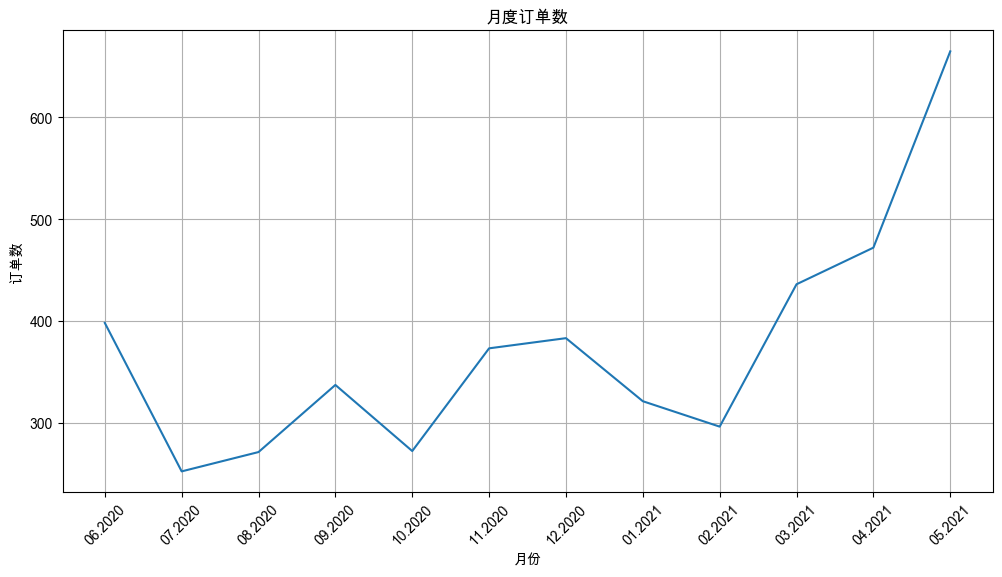

In [20]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
#解决中文显示错误的问题
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS'  # 跨平台（需安装）
]
#构建月度的订单数的DataFrame
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('ME').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

## 数据清洗

In [21]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行
# df_sales = df_sales.loc[df_sales['数量']>0]
df_sales = df_sales[df_sales['数量']>0]

## 特征工程

In [22]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据  

订单号     产品码                消费日期           产品说明  数量     单价    用户码  城市  \
0  536374   21258 2020-06-01 09:09:00        五彩玫瑰五支装  32  10.95  15100  北京   
1  536376   22114 2020-06-01 09:32:00       茉莉花白色25枝  48   3.45  15291  上海   
2  536376   21733 2020-06-01 09:32:00  教师节向日葵3枝尤加利5枝  64   2.55  15291  上海   
3  536378   22386 2020-06-01 09:37:00       百合粉色10花苞  10   1.95  14688  北京   
4  536378  85099C 2020-06-01 09:37:00       橙黄香槟色康乃馨  10   1.95  14688  北京   

      总价  
0  350.4  
1  165.6  
2  163.2  
3   19.5  
4   19.5

## 构建User用户表

In [23]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')] #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

订单号     产品码                消费日期           产品说明  数量     单价    用户码  \
0      536374   21258 2020-06-01 09:09:00        五彩玫瑰五支装  32  10.95  15100   
1      536376   22114 2020-06-01 09:32:00       茉莉花白色25枝  48   3.45  15291   
2      536376   21733 2020-06-01 09:32:00  教师节向日葵3枝尤加利5枝  64   2.55  15291   
3      536378   22386 2020-06-01 09:37:00       百合粉色10花苞  10   1.95  14688   
4      536378  85099C 2020-06-01 09:37:00       橙黄香槟色康乃馨  10   1.95  14688   
...       ...     ...                 ...            ...  ..    ...    ...   
14214  545190   22937 2020-08-29 15:32:00         产品说明掩码   6  18.00  15656   
14215  545190   22722 2020-08-29 15:32:00         产品说明掩码   4  39.50  15656   
14216  545190   22457 2020-08-29 15:32:00         产品说明掩码  60   3.00  15656   
14217  545190   22464 2020-08-29 15:32:00         产品说明掩码  12  25.00  15656   
14218  545190   22423 2020-08-29 15:32:00         产品说明掩码   1  12.75  15656   

       城市      总价  
0      北京  350.40  
1      上海  165.60  
2      上海  163.20  
3      北京   19.50  
4      北京   19.50  
...    ..     ...  
14214  苏州  108.00  
14215  苏州  158.00  
14216  苏州  180.00  
14217  苏州  300.00  
14218  苏州   12.75  

[14219 rows x 9 columns]

In [24]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user.columns = ['用户码'] #设定字段名
df_user.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user = pd.merge(df_user, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user = pd.merge(df_user, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user #显示用户表结构

用户码  R值   F值        M值
0    15100  49    3    876.00
1    15291  41   33   1372.19
2    14688   6   82   1491.37
3    15311   5  693  12859.50
4    15862  89   64    354.23
..     ...  ..  ...       ...
356  15951   1   22    375.17
357  14745   1    7    240.60
358  15724   0    5    103.65
359  15874   0    5    584.35
360  15656   0   15    920.35

[361 rows x 4 columns]

### 构建标签

In [25]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

用户码  R值   F值        M值     年度LTV
0    15100  49    3    876.00    876.00
1    15291  41   33   1372.19   4668.30
2    14688   6   82   1491.37   4949.83
3    15311   5  693  12859.50  59457.10
4    15862  89   64    354.23    659.73
..     ...  ..  ...       ...       ...
356  15951   1   22    375.17    375.17
357  14745   1    7    240.60   1220.26
358  15724   0    5    103.65    218.25
359  15874   0    5    584.35   4405.88
360  15656   0   15    920.35   1425.90

[361 rows x 5 columns]

## 创建特征集和标签集

In [26]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
X.head() #显示特征集

R值   F值        M值
0  49    3    876.00
1  41   33   1372.19
2   6   82   1491.37
3   5  693  12859.50
4  89   64    354.23

In [27]:
y = df_LTV['年度LTV'] #标签集
y.head() #显示标签集

0      876.00
1     4668.30
2     4949.83
3    59457.10
4      659.73
Name: 年度LTV, dtype: float64

## 拆分训练集、验证集和测试集

In [28]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 0)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 0)

In [29]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
scaler = MinMaxScaler() #创建归一化缩放器
X_train = scaler.fit_transform(X_train) #拟合并转换训练集数据
X_valid = scaler.transform(X_valid) #转换验证集数据
X_test = scaler.transform(X_test) #转换测试集数据

## 选择算法创建模型

In [30]:
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_dtr_cut = DecisionTreeRegressor(max_depth=3) #创建深度为3的决策树回归模型

## 训练模型

In [31]:
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_dtr_cut.fit(X_train, y_train) #拟合深度为3的决策树模型
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_dtr_cut = model_dtr_cut.predict(X_valid) #用深度为2的决策树模型预测验证集

## 评估模型

In [32]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('训练集上的R平方分数-决策树: %0.4f' % r2_score(y_train, model_dtr.predict(X_train)))
print('训练集上的R平方分数-深度为2的决策树: %0.4f' % r2_score(y_train, model_dtr_cut.predict(X_train)))
print('测试集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('测试集上的R平方分数-深度为2的决策树: %0.4f' % r2_score(y_valid, model_dtr_cut.predict(X_valid)))

训练集上的R平方分数-决策树: 1.0000
训练集上的R平方分数-深度为2的决策树: 0.9102
测试集上的R平方分数-决策树: 0.8449
测试集上的R平方分数-深度为2的决策树: 0.8961


### 绘图比较

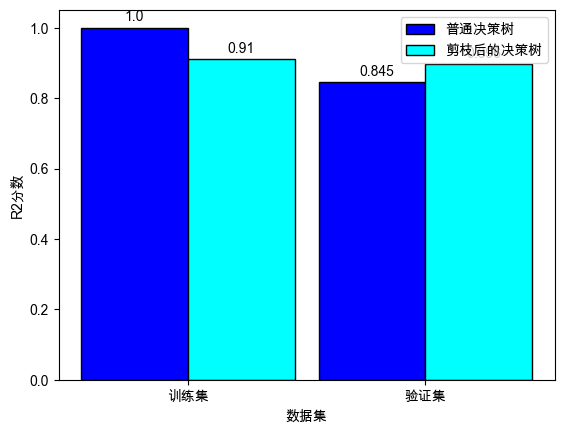

In [33]:
import numpy as np

fig, ax = plt.subplots()    
width = 0.45

# 柱子数据
bars1 = [r2_score(y_train, model_dtr.predict(X_train)),
         r2_score(y_valid, model_dtr.predict(X_valid))]
bars2 = [r2_score(y_train, model_dtr_cut.predict(X_train)),
         r2_score(y_valid, model_dtr_cut.predict(X_valid))]

 
# 柱状图x轴位置
r1 = np.arange(len(bars1))
r2 = [x + width for x in r1]
 
# 柱状图
plt.bar(r1, bars1, width = width, color = 'blue', edgecolor = 'black', capsize=7, label='普通决策树')
plt.bar(r2, bars2, width = width, color = 'cyan', edgecolor = 'black', capsize=7, label='剪枝后的决策树')

# 布局
plt.xticks([r + width/2 for r in range(len(bars1))], ['训练集', '验证集'])
plt.ylabel('R2分数')
plt.xlabel('数据集')
plt.legend()

# 数值标签
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i/50+x[i], round(y[i], 3)+0.02, round(y[i], 3), ha = 'center')
addlabels(r1, bars1)
addlabels(r2, bars2)

# 绘图
plt.show()